# List of planets with mass and distance, Center of Mass for each system
### 1. read the file from exoplanet.eu
List of planets from exoplanet.eu, it is taking mass (and its uncertaintly), semi_major (and its uncertaintly), Metallicity (and its uncertaintly).  

In [103]:
import pandas as pd 
import numpy as np
from scipy.stats import norm # normal distribution
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

data_ep = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                      usecols=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min','star_name',
                               'star_metallicity','star_metallicity_error_min'])

data_ep = data_ep.replace([np.inf, -np.inf], np.nan) # it replaces the inf values
#data_ep
#data_ep.count()

**Remember**: `pd.notnull("name_of_column")` deletes the NaN values in the column. 

**Remember**: `data=data[['column_a','column_b',..,'column_n',]]` to get a new order in the DataFrame

Now is necessary processing the data with the prurpose to obtain the Center of Mass CM, `data1` is a DataFrame without the NaN values of _mass_ and _semi major axis_. Finally, we get 1667 rows.

In [2]:
dataB = data_ep.dropna(subset=['mass','mass_error_min','semi_major_axis',
                               'semi_major_axis_error_min'])
#-----------------------------------------------------------------------
data2 = dataB[['star_name','mass', 'mass_error_min',
               'semi_major_axis','semi_major_axis_error_min']]
#-----------------------------------------------------------------------
print(len(data2))

1217


So, `data2` is a DataFrame without the NaN values of mass, semi major axis and their uncertainties. Finally, we get 1217 rows, 445 rows less than `data1`. 

For the semi major axes column, withouth NaN values we have `data3`, it is usefull for planetary systems with one planet observed.

### 2. Center of Mass 
We need to estimate the CM for each planet, so:
\begin{equation*}
\text{CM} = \frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{\sum \limits_{k=1}^{n}m_{k}} %=\frac{\sum\limits_{k=1}^n(m_{k}\vec{r_{k}})}{M_{T}}
\end{equation*}
For do it, is nessesary get the values CM for each planet, so with the columns of `mass` and distance from the star  `semi_major_axis` we can get $\boxed{m_{k}\vec{r_{k}}}$ values.

**Remember:** The `data.groupby("key")` split the data in groups which are the key.

**Remember:** The `data[i].multiply(data[j])` multiplies the comun i and j of DataFrame or Series i and j, row by row.

**Remember:** The `data.groupby.groups.keys()` get the keys of the split data.

#### Employing  `data2`: #### 

In [3]:
r_i = data2["semi_major_axis"]
m_i = data2["mass"]
#----------------------------------------------------------------------
#the multiplications between columns, new column CM_i:
data2 = data2.assign(CM_i=r_i.multiply(m_i))  
#----------------------------------------------------------------------
#value, for each planet in the system. 
p_system = data2.groupby("star_name")
#----------------------------------------------------------------------
#(np.isnan(data1.CM_i)).sum()

However, the calculus of the CM, counting the planetary systems with the same satar. 

### 3. Gaussian Mixture Model
#### Center of Mass
The Gaussian Mixture model: 

In [4]:
#The total mass, for each system: 
M_total = p_system["mass"].sum()#.tolist() changes from Series to list
#----------------------------------------------------------------------
#The sum of the CM_i for each system:
sum_rm = p_system['CM_i'].sum()#.tolist()
#----------------------------------------------------------------------
#total center of mass, for each extraplanetary system
CM = sum_rm.divide(M_total)
#----------------------------------------------------------------------
system = list(p_system.groups.keys())
#system
#----------------------------------------------------------------------
#the data after get the Center of Mass for each system 
data = pd.DataFrame({'system_name':system,
                     'total_mass':M_total.tolist(),
                     'center_of_Mass':CM.tolist()})
#len(data1) 
#(np.isnan(data1.center_of_Mass)).sum()

(-0.1, 0.1)

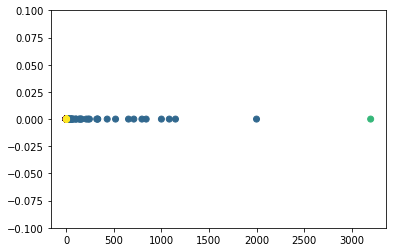

In [5]:
#GaussianMixture: 
#number of parametres, 
#each parameter has its own covariance type

gmm = GaussianMixture(4, covariance_type='full', random_state=0)
CM=data[["center_of_Mass"]]
gmm.fit(CM.values)
cluster_label = gmm.predict(CM.values)
plt.scatter((CM.values),np.zeros(len(CM)), c=cluster_label);
plt.ylim(-0.1,0.1)

The Bayesian information criterion

In [6]:
#Bayesian information criterion 
bic=[]
for i in range(10):
    i+=1
    gmm = GaussianMixture(i, covariance_type='full', random_state=0)
    CM_log=np.log10(data[["center_of_Mass"]])
    gmm.fit(CM_log.values)
    bic+=[gmm.bic(CM_log.values)]
#bic

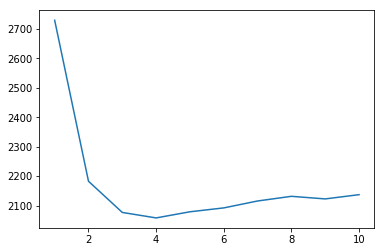

In [7]:
plt.plot(range(1,11),bic)

(-0.1, 1)

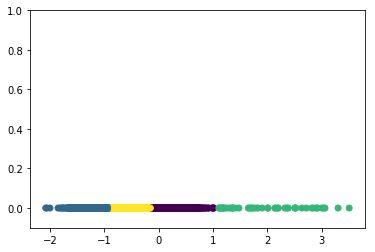

In [8]:
# GaussianMixture, for the log of CM: 
# 4 groups due tu the bic
gmm = GaussianMixture(4, covariance_type='full', random_state=0)
CM_log=np.log10(data[["center_of_Mass"]])
gmm.fit(CM_log.values)
cluster_label = gmm.predict(CM_log.values)
plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=cluster_label);
plt.ylim(-0.1,1)

The probabilities or verisimilitudes, are defined by normal distribution for each group from the gaussian mixture model:

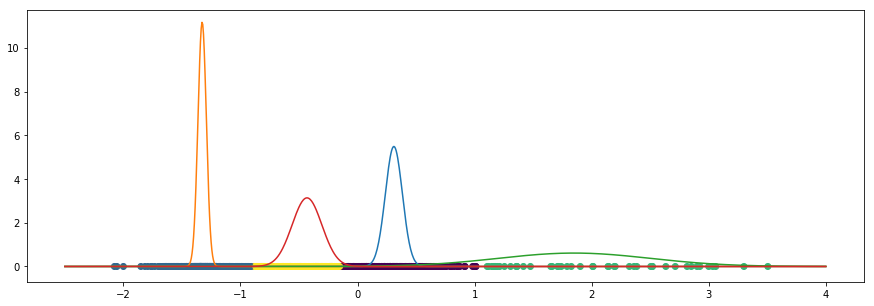

In [9]:
#gmm.means_
plt.figure(figsize=(15,5))
sma=np.linspace(-2.5,4,1000)
#-----------------------------------------------------------------------
#a normal distribution for each group
for m,s in zip(gmm.means_,gmm.covariances_):
    plt.plot(sma, norm.pdf(sma,m,s)[0])
#-----------------------------------------------------------------------
# Each group
plt.scatter((CM_log.values),np.zeros(len(CM_log)),c=cluster_label);

The posteriror probabilities are determinated by the function `gmm.predict_proba()`

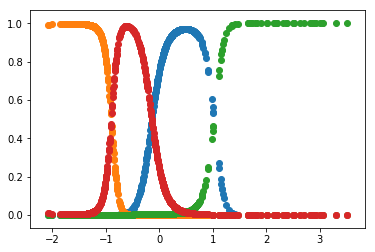

In [10]:
# The posterior probabilities: 
for i in range(4):
    plt.scatter(CM_log,gmm.predict_proba(CM_log)[:,i]);

The probability for a synthetic draw of a system called AA, with a $\mu=0.8$ and $\sigma=0.03$ in the CM, can be established as:

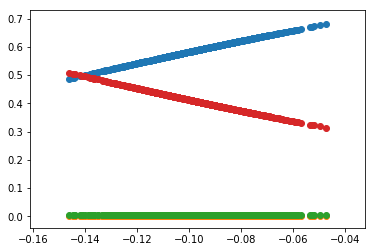

In [11]:
AA=np.log10(np.random.normal(0.8,0.03,1000))
AA=AA[:,np.newaxis]

for i in range(4):
    plt.scatter(AA,gmm.predict_proba(AA)[:,i])

## ... Draws
Employing m and $\Delta$m, a and $\Delta$a, from `data2`.

In [61]:
# Group the planetary system:
Planetary_System = data2.groupby("star_name")
Systems_List = list(Planetary_System.groups.keys())

A first way to get the drows for each system:

In [133]:
%%time
#-------------------------------------------------------------------------
# Drows, for each planetary system
draws=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    system_i = data2[data2.star_name == Systems_List[i]]    
    draw_i=[]
    for j in  range(1000):
        #Get random values for each planet in a system and the COM for those values
        masses=np.random.normal(system_i.mass,system_i.mass_error_min)
        axes=np.random.normal(system_i.semi_major_axis,
                              system_i.semi_major_axis_error_min)
        draw_i += [(masses*axes).sum()/masses.sum()]
    draws.append(draw_i)


CPU times: user 2min 51s, sys: 791 ms, total: 2min 51s
Wall time: 2min 50s


Second way to get the draws for each system (in a shorter time):

In [132]:
%%time
DrawsA=[]#drows of COM for each system. 
for i in range(len(Systems_List)):
    SystemA_i = data2[data2.star_name == Systems_List[i]]  
    Mass_System = np.zeros(1000)
    Mass_Axe = np.zeros(1000) 
    for k in range(len(SystemA_i)):
        Masses = np.random.normal(SystemA_i.mass.values[k],
                                  SystemA_i.mass_error_min.values[k],1000)
        Axes = np.random.normal(SystemA_i.semi_major_axis.values[k],
                                SystemA_i.semi_major_axis_error_min.values[k],
                                1000)
        Mass_Axe += Masses*Axes
        Mass_System += Masses
        #print(SystemA_i.mass.values[k])
    DrawsA.append([Mass_Axe/Mass_System])
#len(DrawsA[0][0])

CPU times: user 1.35 s, sys: 3.97 ms, total: 1.35 s
Wall time: 1.35 s


In [194]:
SystemA_i = data2[data2.star_name == Systems_List[2]]  
SystemA_i
#type(DrawsA[2][0])#[987)

,star_name,mass,mass_error_min,semi_major_axis,semi_major_axis_error_min,CM_i
0,11 Com,19.4,1.5,1.29,0.05,25.026


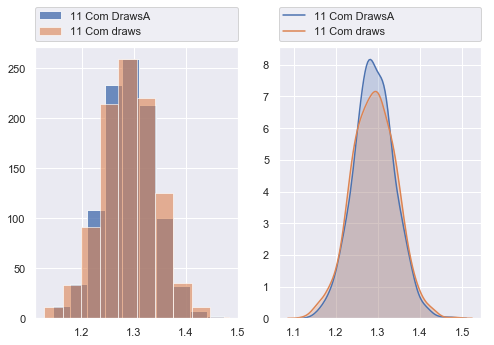

In [195]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

f1 = ax1.hist(DrawsA[2][0],10,alpha=0.8,label=Systems_List[2]+" DrawsA")
f2 = ax1.hist(draws[2],10, alpha=0.6,label=Systems_List[2]+" draws")
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)
f2 = sns.kdeplot(DrawsA[2][0], shade=True,label=Systems_List[2]+" DrawsA")
f3 = sns.kdeplot(draws[2], shade=True,label=Systems_List[2]+" draws")
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=1, mode="expand", borderaxespad=0.)

The probability of each draw to belong a each group, taking draws form `DrawsA`

In [199]:
# CM_log is the centero of mass in log scale for each system
Draw_i=np.log10(DrawsA[986][0][:,np.newaxis])
orig=gmm.predict(np.array(CM_log))[986]
(orig!=gmm.predict(Draw_i)).sum()/1000 # AA es el elemento i de draws (que debe ser un array de 1000 elementos)
#orig
#AA
#orig=gmm.predict(np.array([[0.8]])) # 0.8 es el centro de masa para el sistema i
#(orig!=gmm.predict(AA)).sum()/1000 # AA es el elemento i de draws (que debe ser un array de 1000 elementos)
#DrawsA[0]
#Draw_i=DrawsA[0][0][:,np.newaxis]
#gmm.predict(Draw_i)
#Draw_i
#gmm.predict(Draw_i)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [196]:
orig=gmm.predict(np.array(CM_log))[2]
print(CM_log.values)
DrawsA[2][0]



[[ 2.30448921e-01]
 [-3.74687549e-01]
 [ 1.10589710e-01]
 [ 2.38560627e+00]
 [ 1.87520721e-01]
 [ 4.42479769e-01]
 [ 2.25309282e-01]
 [ 2.51851394e+00]
 [ 5.91064607e-01]
 [-7.21246399e-01]
 [ 1.92681873e-01]
 [-3.62121727e-02]
 [ 1.71600334e+00]
 [ 2.19312460e+00]
 [ 1.17609126e+00]
 [ 4.61948495e-01]
 [ 1.66275783e+00]
 [ 5.47774705e-01]
 [ 6.51278014e-01]
 [ 2.36172784e+00]
 [ 2.71432976e+00]
 [-2.17691925e-03]
 [ 2.60071388e-01]
 [-6.04807474e-02]
 [ 7.55469614e-02]
 [ 7.46620979e-01]
 [ 1.14612804e+00]
 [ 6.24403853e-01]
 [-4.85225019e-01]
 [ 2.85557309e-01]
 [-3.09803920e-01]
 [-7.90484985e-01]
 [ 1.64352856e-01]
 [ 1.13943352e-01]
 [-2.39577517e-01]
 [-1.18045606e+00]
 [-6.17982957e-01]
 [-3.01029996e-01]
 [ 7.55469614e-02]
 [ 6.23249290e-01]
 [-2.24962274e-01]
 [-2.18158493e-01]
 [ 3.57934847e-01]
 [ 1.27104798e-01]
 [ 1.82607480e+00]
 [ 4.14973348e-01]
 [-2.07675598e+00]
 [-1.59516628e+00]
 [-9.76747540e-01]
 [-1.36141092e+00]
 [-1.39620630e+00]
 [-1.29242982e+00]
 [-1.5686362

array([1.27198855, 1.33688522, 1.35690842, 1.31005644, 1.44711754,
       1.32441879, 1.17322306, 1.29187988, 1.19676192, 1.29255129,
       1.29451836, 1.32249255, 1.31297469, 1.27260109, 1.30756864,
       1.33237729, 1.40687593, 1.28551807, 1.34714432, 1.27492153,
       1.26520041, 1.17976965, 1.28958607, 1.30450528, 1.37332822,
       1.28581217, 1.26016082, 1.23711204, 1.26650264, 1.30552043,
       1.23840103, 1.2754351 , 1.28504538, 1.26274301, 1.25377345,
       1.23774574, 1.25779617, 1.31435088, 1.30981404, 1.28666382,
       1.32947873, 1.30001094, 1.28910822, 1.256361  , 1.32331925,
       1.2897879 , 1.30893401, 1.27340023, 1.26288784, 1.27669534,
       1.34868916, 1.35169645, 1.34709956, 1.27205155, 1.2525878 ,
       1.26379933, 1.23925888, 1.25970131, 1.33985681, 1.231486  ,
       1.29368731, 1.28719336, 1.30083825, 1.2698201 , 1.23871835,
       1.31007717, 1.37054612, 1.29535944, 1.23687929, 1.3075757 ,
       1.24823778, 1.29018505, 1.2844974 , 1.35934603, 1.37107

#### Metallicity

In [196]:
dataMet = data_ep[pd.notnull(data_ep["star_metallicity"])]
dataMetA = dataMet[pd.notnull(dataMet["star_metallicity_error_min"])]
dataMet = dataMetA[['star_name',"star_metallicity","star_metallicity_error_min"]]

In [195]:
gmm2 = GaussianMixture(3, covariance_type='full', random_state=0)
B=dataMet[["star_metallicity"]]
gmm2.fit(B.values)
cluster_label = gmm2.predict(B.values)
B.values[:, 0]
plt.scatter((B.values),np.zeros(len(B)), c=cluster_label);
plt.ylim(-0.1,1)

NameError: name 'dataMet' is not defined

In [30]:
bic=[]
for i in range(15):
    i+=1
    gmm2 = GaussianMixture(i, covariance_type='full', random_state=0)
    A=data1[["center_of_Mass"]]
    gmm2.fit(B.values)
    bic+=[gmm2.bic(B.values)]
plt.plot(range(1,16),bic)

NameError: name 'data1' is not defined

NameError: name 'A' is not defined

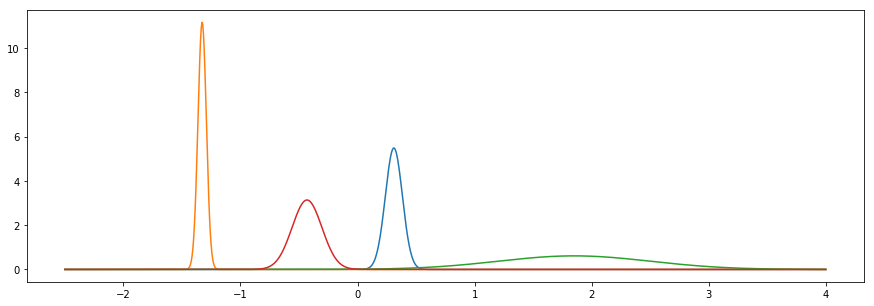

In [31]:
plt.figure(figsize=(15,5))
sma=np.linspace(-2.5,4,1000)
for m,s in zip(gmm.means_,gmm.covariances_):
    plt.plot(sma, norm.pdf(sma,m,s)[0])
plt.scatter((A.values),np.zeros(len(A)), c = cluster_label);